=== STARTING MARKET TREND ANALYSIS SYSTEM ===

[1] Loading Data...
    Data loaded: 30000 rows, 12 columns.
    Date Range: 1902-09-08 to 2017-09-01

[2] Performing Exploratory Data Analysis...
    Saved plot: eda_price_trend.png
    Saved plot: eda_returns_volatility.png

[3] Detecting Market Trends...
    Current Market Status (2017-09-01):
    - Price: 26.73
    - Trend: BULLISH (Price vs SMA_50)
    - RSI: 69.25 -> Neutral

[4] Running Prophet Model (Baseline)...


15:54:27 - cmdstanpy - INFO - Chain [1] start processing
15:54:40 - cmdstanpy - INFO - Chain [1] done processing


    Prophet RMSE: 2.7005
    Prophet MAPE: 10.0000%

[5] Running LSTM Model (Deep Learning)...
    Training LSTM (this may take a moment)...
    LSTM RMSE: 1.3115
    LSTM MAPE: 4.8312%

[6] Final Model Comparison & Insights
    Model      | RMSE       | MAPE      
------------------------------------
    Prophet    | 2.7005     | 10.0000%  
    LSTM       | 1.3115     | 4.8312%   

    >>> CONCLUSION: The LSTM model performed better on this dataset.
    >>> INSIGHT: LSTM generally captures complex non-linear patterns better,
                 while Prophet is robust for seasonality and trends.

*** DISCLAIMER: This is an academic project. Not financial advice. ***
=== ANALYSIS COMPLETE ===


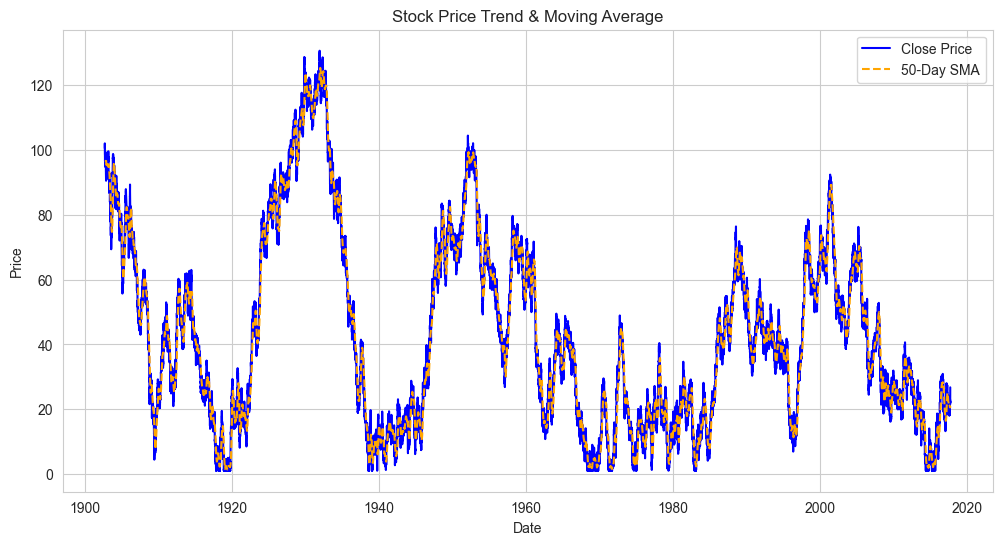

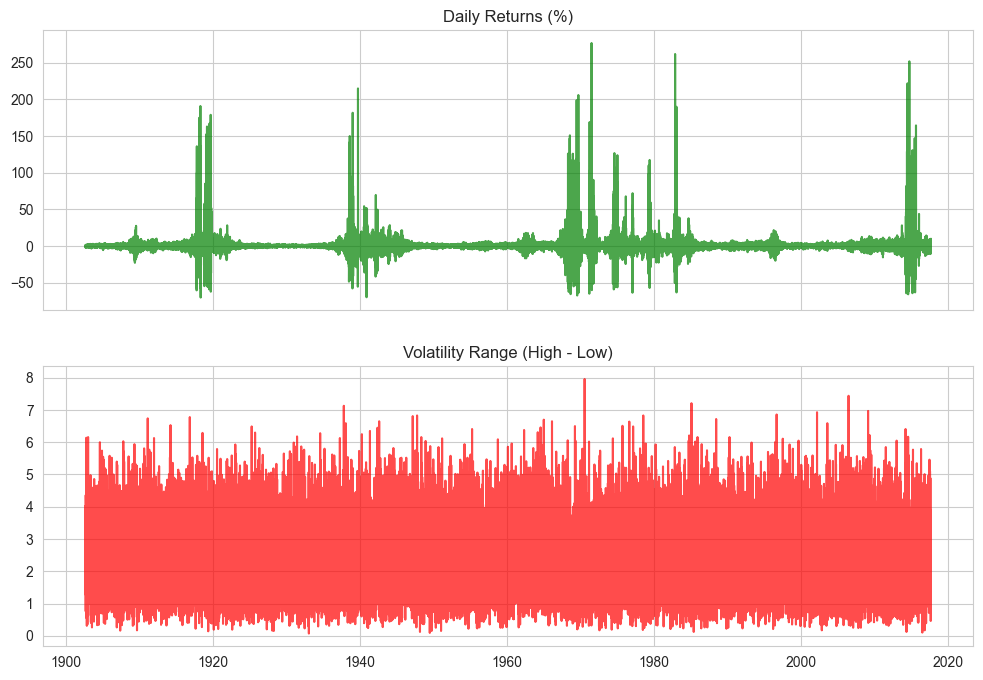

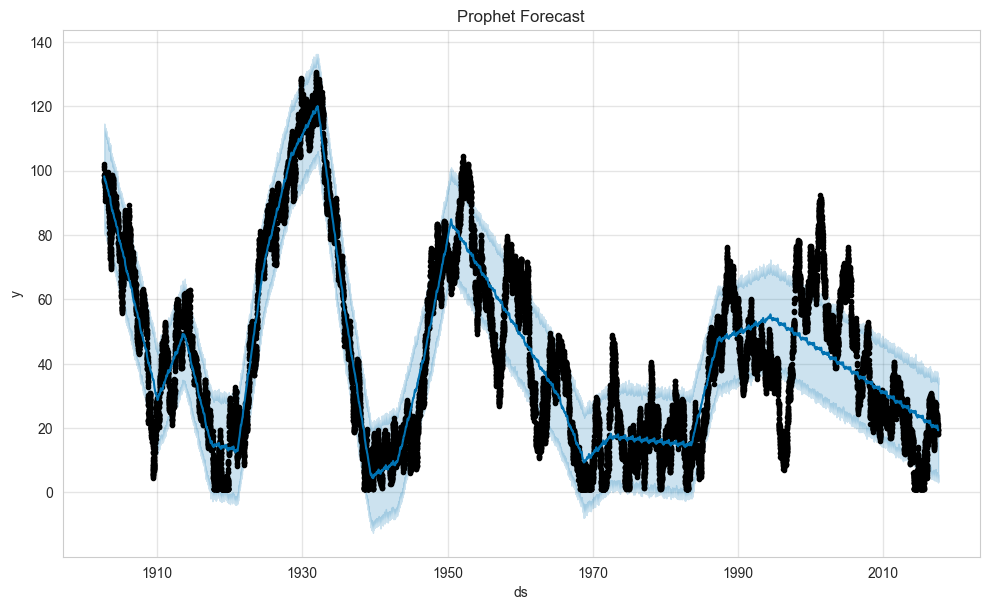

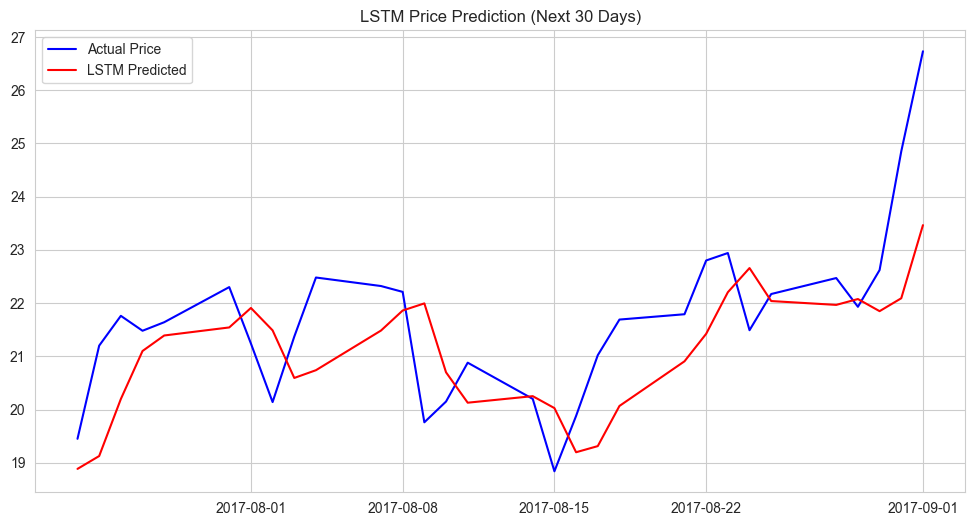

In [ ]:
"""
=========================================================
Project: AI for Market Trend Analysis using Financial Time-Series Data
Author: [BHAVESH DEWANGAN - iitrprai_24102163]
Course: IIT Ropar Minor in AI (Module E)


Objective:
  - Analyze stock market trends.
  - Forecast prices using Prophet (Statistical) and LSTM (Deep Learning).
  - Compare models and generate insights.
=========================================================
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Modeling Libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from prophet import Prophet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input

# Configuration
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
DATA_FILE = 'Market_Trend_Analysis.csv'

# 1. Data Loading & Preprocessing

def load_and_preprocess(filepath):
    print("\n[1] Loading Data...")
    df = pd.read_csv(filepath)
    
    # Parse dates and sort
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date').reset_index(drop=True)
    
    # Handle missing values (Forward fill for time-series)
    if df.isnull().sum().sum() > 0:
        print(f"    Found {df.isnull().sum().sum()} missing values. Imputing...")
        df.ffill(inplace=True)
    
    print(f"    Data loaded: {df.shape[0]} rows, {df.shape[1]} columns.")
    print(f"    Date Range: {df['Date'].min().date()} to {df['Date'].max().date()}")
    return df


# 2. Exploratory Data Analysis (EDA)

def perform_eda(df):
    print("\n[2] Performing Exploratory Data Analysis...")
    
    # Plot 1: Close Price History
    plt.figure()
    plt.plot(df['Date'], df['Close_Price'], label='Close Price', color='blue')
    plt.plot(df['Date'], df['SMA_50'], label='50-Day SMA', color='orange', linestyle='--')
    plt.title('Stock Price Trend & Moving Average')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.savefig('eda_price_trend.png')
    print("    Saved plot: eda_price_trend.png")
    
    # Plot 2: Daily Returns & Volatility
    fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    ax[0].plot(df['Date'], df['Daily_Return_Pct'], color='green', alpha=0.7)
    ax[0].set_title('Daily Returns (%)')
    ax[1].plot(df['Date'], df['Volatility_Range'], color='red', alpha=0.7)
    ax[1].set_title('Volatility Range (High - Low)')
    plt.savefig('eda_returns_volatility.png')
    print("    Saved plot: eda_returns_volatility.png")


# 3. Market Trend Detection

def detect_trends(df):
    print("\n[3] Detecting Market Trends...")
    
    # Determine current trend based on Price vs SMA
    last_row = df.iloc[-1]
    trend = "BULLISH" if last_row['Close_Price'] > last_row['SMA_50'] else "BEARISH"
    
    # RSI Interpretation
    rsi = last_row['RSI_14']
    rsi_signal = "Neutral"
    if rsi > 70: rsi_signal = "Overbought (Sell Risk)"
    elif rsi < 30: rsi_signal = "Oversold (Buy Opportunity)"
    
    print(f"    Current Market Status ({last_row['Date'].date()}):")
    print(f"    - Price: {last_row['Close_Price']:.2f}")
    print(f"    - Trend: {trend} (Price vs SMA_50)")
    print(f"    - RSI: {rsi:.2f} -> {rsi_signal}")

# 4. Model 1: Prophet (Baseline)

def run_prophet_model(df, periods=30):
    print("\n[4] Running Prophet Model (Baseline)...")
    
    # Prepare data for Prophet (ds, y)
    prophet_df = df[['Date', 'Close_Price']].rename(columns={'Date': 'ds', 'Close_Price': 'y'})
    
    # Train-Test Split (Last 30 days for validation)
    train_size = len(prophet_df) - periods
    train_df = prophet_df.iloc[:train_size]
    test_df = prophet_df.iloc[train_size:]
    
    # Fit Model
    model = Prophet(daily_seasonality=True, yearly_seasonality=True)
    model.fit(train_df)
    
    # Forecast
    future = model.make_future_dataframe(periods=periods)
    forecast = model.predict(future)
    
    # Evaluate
    preds = forecast['yhat'].iloc[-periods:].values
    actuals = test_df['y'].values
    rmse = np.sqrt(mean_squared_error(actuals, preds))
    mape = mean_absolute_percentage_error(actuals, preds)
    
    # Plot
    model.plot(forecast)
    plt.title('Prophet Forecast')
    plt.savefig('forecast_prophet.png')
    
    print(f"    Prophet RMSE: {rmse:.4f}")
    print(f"    Prophet MAPE: {mape:.4%}")
    return rmse, mape


# 5. Model 2: LSTM (Deep Learning)

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), 0])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

def run_lstm_model(df, look_back=60, forecast_days=30):
    print("\n[5] Running LSTM Model (Deep Learning)...")
    
    # Data Preparation
    data = df[['Close_Price']].values
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)
    
    # Split Data (Keep last `forecast_days` for testing)
    train_size = len(scaled_data) - forecast_days
    train_data = scaled_data[:train_size]
    test_data = scaled_data[train_size - look_back:] # Need look_back buffer
    
    # Create Sequences
    X_train, y_train = create_sequences(train_data, look_back)
    X_test, y_test = create_sequences(test_data, look_back)
    
    # Reshape for LSTM [samples, time steps, features]
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    # Build Model
    model = Sequential([
        Input(shape=(X_train.shape[1], 1)),
        LSTM(50, return_sequences=False),
        Dense(25),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Train (Verbose=0 to keep output clean)
    print("    Training LSTM (this may take a moment)...")
    model.fit(X_train, y_train, batch_size=32, epochs=5, verbose=0)
    
    # Predict
    predictions = model.predict(X_test, verbose=0)
    predictions = scaler.inverse_transform(predictions)
    
    # Evaluate
    actuals = data[-forecast_days:]
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    mape = mean_absolute_percentage_error(actuals, predictions)
    
    # Plot
    plt.figure()
    plt.plot(df['Date'].iloc[-forecast_days:], actuals, label='Actual Price', color='blue')
    plt.plot(df['Date'].iloc[-forecast_days:], predictions, label='LSTM Predicted', color='red')
    plt.title('LSTM Price Prediction (Next 30 Days)')
    plt.legend()
    plt.savefig('forecast_lstm.png')
    
    print(f"    LSTM RMSE: {rmse:.4f}")
    print(f"    LSTM MAPE: {mape:.4%}")
    return rmse, mape


# 6. Main Execution Pipeline

if __name__ == "__main__":
    print("=== STARTING MARKET TREND ANALYSIS SYSTEM ===")
    
    # 1. Load Data
    df = load_and_preprocess(DATA_FILE)
    
    # 2. EDA
    perform_eda(df)
    
    # 3. Trend Detection
    detect_trends(df)
    
    # 4. Prophet Model
    rmse_p, mape_p = run_prophet_model(df, periods=30)
    
    # 5. LSTM Model
    rmse_l, mape_l = run_lstm_model(df, look_back=60, forecast_days=30)
    
    # 6. Comparison & Conclusion
    print("\n[6] Final Model Comparison & Insights")
    print(f"    {'Model':<10} | {'RMSE':<10} | {'MAPE':<10}")
    print("-" * 36)
    print(f"    {'Prophet':<10} | {rmse_p:<10.4f} | {mape_p:<10.4%}")
    print(f"    {'LSTM':<10} | {rmse_l:<10.4f} | {mape_l:<10.4%}")
    
    winner = "LSTM" if rmse_l < rmse_p else "Prophet"
    print(f"\n    >>> CONCLUSION: The {winner} model performed better on this dataset.")
    print("    >>> INSIGHT: LSTM generally captures complex non-linear patterns better,")
    print("                 while Prophet is robust for seasonality and trends.")
    
    # Disclaimer
    print("\n*** DISCLAIMER: This is an academic project. Not financial advice. ***")
    print("=== ANALYSIS COMPLETE ===")